# `CLOUD.jl` - 3D linear advection example

In [34]:
using CLOUD, OrdinaryDiffEq, Plots, Plots.PlotMeasures, TimerOutputs

## Define the physical problem

In [35]:
θ = π/4 # wave angle
a = sqrt(2) # wave speed
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(sin(θ)))) # end time for one period
CFL = 0.1

conservation_law = LinearAdvectionEquation((a*cos(θ),a*sin(θ),0.0))
initial_data = InitialDataCosine(A,k)
exact_solution = ExactSolution(conservation_law,initial_data);

## Set discretization parameters

In [36]:
M = 4
p = 4
p_map = 3
form = WeakConservationForm(mapping_form=StandardMapping(), 
    inviscid_numerical_flux=LaxFriedrichsNumericalFlux(1.0))
ode_algorithm = CarpenterKennedy2N54();

## Set up a `ModalTensor` scheme of degree `p` with `M` edges in each direction

In [37]:
reference_approximation = ReferenceApproximation(
    ModalTensor(p), Tet(), mapping_degree=p_map)

uniform_mesh = uniform_periodic_mesh(reference_approximation,
    ((0.0,L),(0.0,L),(0.0,L)), (M,M,M))

mesh = warp_mesh(uniform_mesh, reference_approximation, 0.1, L) 

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation, project_jacobian=true)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T),
     "results/advection_3d/", overwrite=true, clear=true);

## Run the solver, using a weight-adjusted approximation of the mass matrix inverse

In [38]:
h = L/(reference_approximation.N_p * spatial_discretization.N_e)^(1/3)
dt = CFL * h / a

ode_problem_1 = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T),
    mass_matrix_solver=WeightAdjustedSolver())

reset_timer!()
sol = solve(ode_problem_1, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, 
    callback=save_callback(results_path, (0.0,T), floor(Int, T/(dt*50))))
print_timer()

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            1504s / 100.0%            559GiB / 100.0%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 du/dt                  1.74k    1503s  100.0%   862ms    559GiB  100.0%   328MiB
   eval residual        1.74k    1286s   85.6%   737ms    484GiB   86.6%   284MiB
   reconstruct noda...  1.74k     217s   14.4%   125ms   75.1GiB   13.4%  44.1MiB
 ────────────────────────────────────────────────────────────────────────────────


## Calculate the integral L<sup>2</sup> error norm 

In [39]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), initial_data, T)...)

L2 error:
0.006081964660518125


## Analyze conservation and energy dissipation

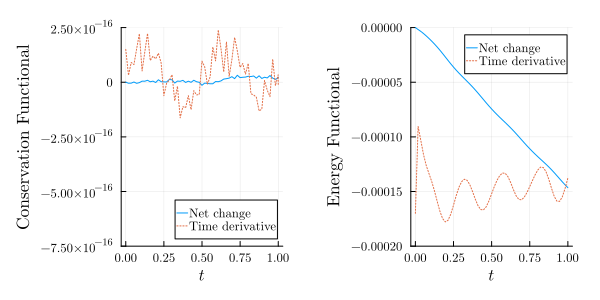

In [40]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization, true)
p1 = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
        ylabel="Conservation Functional", ylims=[-7.5e-16,2.5e-16])
p2 = plot(analyze(energy_analysis, load_time_steps(results_path)),
    ylabel="Energy Functional", ylims=[-2e-4,0.0])
plot(p1,p2, size=(600,300),margin=5mm, fmt=:png)

## Postprocess for VTK visualization

In [41]:
for i in eachindex(sol.u)
    postprocess_vtk(spatial_discretization,
        string(results_path,"vis_", lpad(i,3,"0"), ".vtu"),
            sol.u[i],p_map=p_map,p_vis=p)
end